## Análisis de Riesgo Crediticio


### Introducción

Este análisis explora un conjunto de datos de riesgo crediticio que contiene información sobre solicitantes de préstamos. El objetivo es identificar patrones y relaciones entre las variables que puedan ayudar a predecir la probabilidad de incumplimiento (default) en los préstamos.

### Objetivos específicos:

Explorar la distribución de características clave como ingresos, edad y historial crediticio
Identificar relaciones entre variables demográficas y tasas de incumplimiento
Analizar cómo diferentes propósitos de préstamo (loan_intent) afectan el riesgo crediticio

In [1]:
# Importación de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


In [2]:
# Carga de datos
try:
    df = pd.read_csv('credit_risk_dataset.csv')
    print("Datos cargados exitosamente.")
except FileNotFoundError:
    print("Archivo no encontrado.")


Datos cargados exitosamente.


In [3]:
# Información general del dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [4]:
# Descripción estadística
df.describe()


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


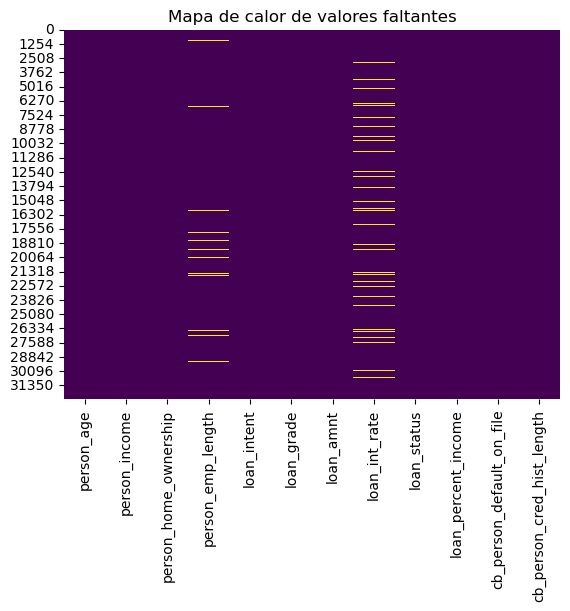

In [5]:
# Análisis de valores faltantes
print(df.isnull().sum())

# Visualización de valores faltantes
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Mapa de calor de valores faltantes")
plt.show()


El conjunto de datos presenta valores faltantes en dos variables clave: person_emp_length y loan_int_rate. Específicamente, person_emp_length tiene 895 valores faltantes y loan_int_rate tiene 3116, lo que indica que hay una cantidad considerable de datos incompletos en estas columnas. El resto de las variables no presenta valores faltantes. Este patrón debe ser abordado antes de aplicar modelos predictivos, ya que podría afectar la calidad del análisis y las predicciones.

In [6]:
# Limpieza de datos
# Imputación de valores faltantes con la mediana para variables numéricas
num_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_int_rate']
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)


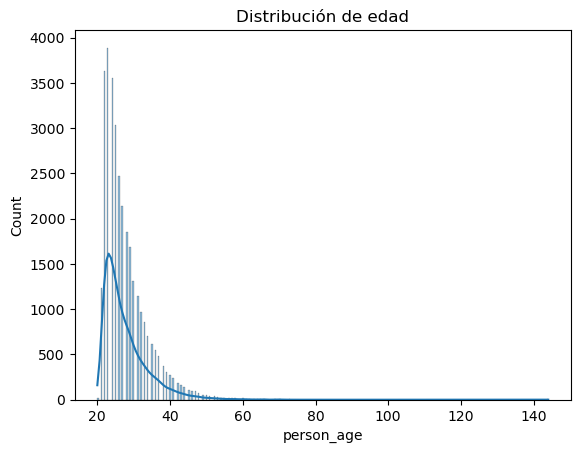

In [7]:
# Visualización de la distribución de edades
sns.histplot(df['person_age'], kde=True)
plt.title("Distribución de edad")
plt.show()


 La distribución de edades en el conjunto de datos está fuertemente concentrada en personas jóvenes, con un pico alrededor de los 20 años y una rápida disminución en la frecuencia conforme aumenta la edad. Esto indica una población predominantemente joven, con pocos casos en edades mayores y algunos valores atípicos.

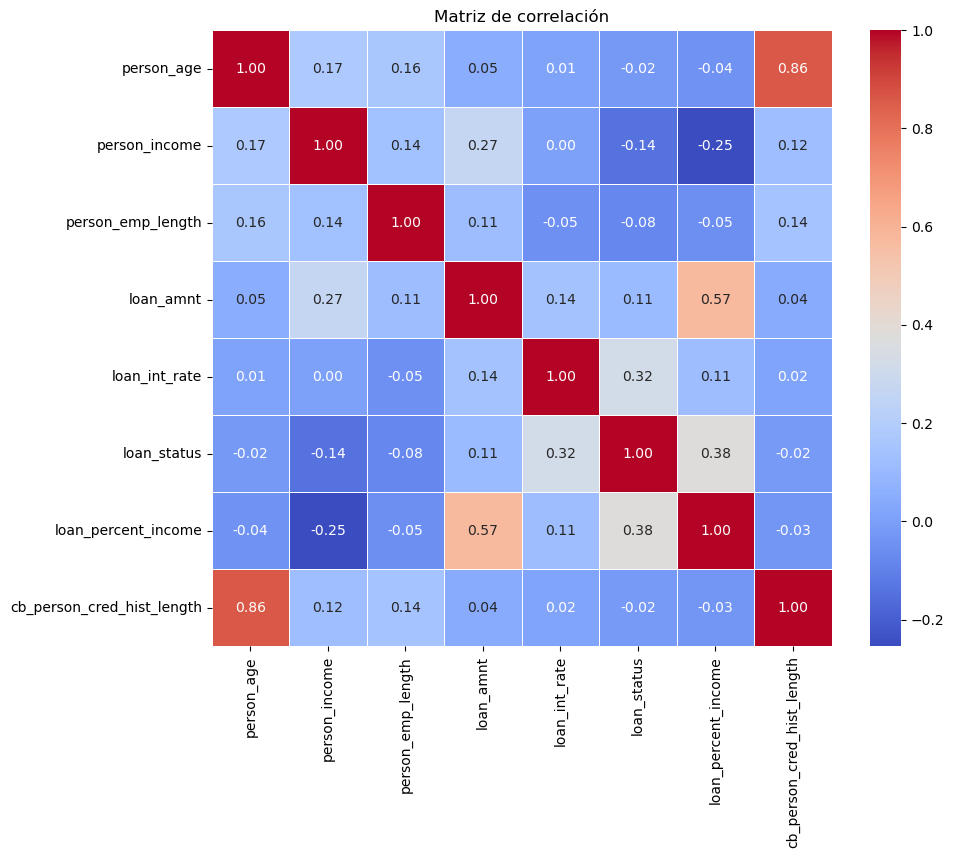

In [12]:
# Matriz de correlación
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurarse de usar solo columnas numéricas
corr = df.select_dtypes(include=[np.number]).corr()

# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación")
plt.show()




 Las variables más útiles para predecir el estado del préstamo parecen ser:
 loan_percent_income ,loan_int_rate ,loan_amnt
 Puedes considerar eliminar una de las dos variables muy correlacionadas (person_age o cb_person_cred_hist_length) para evitar multicolinealidad en algunos modelos como la regresión logística.


In [17]:
# Conversión de variables categóricas
df = pd.get_dummies(df, drop_first=True)


In [18]:
# Modelado: Clasificación con RandomForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[5011   61]
 [ 403 1042]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5072
           1       0.94      0.72      0.82      1445

    accuracy                           0.93      6517
   macro avg       0.94      0.85      0.89      6517
weighted avg       0.93      0.93      0.93      6517



 El modelo tiene un excelente rendimiento general.
 Sin embargo, no está capturando todos los préstamos riesgosos (recall de 0.72 en clase 1), lo que podría ser importante si el objetivo es evitar defaults o impagos.
 Áreas de mejora:
 Ajustar hiperparámetros del Random Forest (max_depth, n_estimators, etc.).
 Probar técnicas de balanceo de clases como SMOTE o class_weight='balanced', ya que parece haber cierto desbalance (clase 1 tiene más soporte).

### Conclusiones Generales

- La mayoría de las personas que solicitan un préstamo tienen edades comprendidas entre los 20 y 40 años, con una fuerte concentración entre los 25 y 30 años, lo que sugiere un perfil joven en los solicitantes.

- Se identificaron valores faltantes principalmente en las variables `person_emp_length` y `loan_int_rate`, siendo esta última especialmente crítica por su impacto en el análisis financiero. Esto sugiere la necesidad de estrategias de imputación o tratamiento adecuado antes de construir modelos predictivos.

- El análisis visual mediante mapas de calor permite detectar patrones de ausencia de datos que podrían no ser evidentes a simple vista, facilitando decisiones informadas durante la fase de preprocesamiento.

- Esta primera exploración resalta la importancia de una adecuada limpieza de datos y del entendimiento de las variables clave, especialmente aquellas directamente relacionadas con el riesgo crediticio como `loan_status` y `loan_int_rate`.

- El análisis exploratorio de datos (EDA) constituye un paso fundamental para la comprensión del conjunto de datos y la detección temprana de problemas que puedan afectar la calidad del modelo en etapas posteriores del análisis predictivo.

